# CITEseq Quickstart

This notebook shows how to get a baseline model and prediction for the CITEseq part of the *Multimodal Single-Cell Integration* competition without running out of memory.

It does not show the EDA - see the separate notebook [MSCI EDA which makes sense ⭐️⭐️⭐️⭐️⭐️](https://www.kaggle.com/ambrosm/msci-eda-which-makes-sense).

The quickstart notebook for the Multiome part of the competition is [here](https://www.kaggle.com/ambrosm/msci-multiome-quickstart).

In [1]:
import os, gc, pickle
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from colorama import Fore, Back, Style
from matplotlib.ticker import MaxNLocator

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler, scale
from sklearn.decomposition import PCA
from sklearn.dummy import DummyRegressor
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.linear_model import Ridge
from sklearn.compose import TransformedTargetRegressor
from sklearn.metrics import mean_squared_error

DATA_DIR = "./input/"
FP_CELL_METADATA = os.path.join(DATA_DIR,"metadata.csv")

FP_CITE_TRAIN_INPUTS = os.path.join(DATA_DIR,"train_cite_inputs.h5")
FP_CITE_TRAIN_TARGETS = os.path.join(DATA_DIR,"train_cite_targets.h5")
FP_CITE_TEST_INPUTS = os.path.join(DATA_DIR,"test_cite_inputs.h5")

FP_MULTIOME_TRAIN_INPUTS = os.path.join(DATA_DIR,"train_multi_inputs.h5")
FP_MULTIOME_TRAIN_TARGETS = os.path.join(DATA_DIR,"train_multi_targets.h5")
FP_MULTIOME_TEST_INPUTS = os.path.join(DATA_DIR,"test_multi_inputs.h5")

FP_SUBMISSION = os.path.join(DATA_DIR,"sample_submission.csv")
FP_EVALUATION_IDS = os.path.join(DATA_DIR,"evaluation_ids.csv")

In [2]:
# If you see a warning "Failed to establish a new connection" running this cell,
# go to "Settings" on the right hand side, 
# and turn on internet. Note, you need to be phone verified.
# We need this library to read HDF files.
# !pip install --quiet tables


# Loading the common metadata table

The current version of the model is so primitive that it doesn't use the metadata, but we load it anyway.

In [3]:
df_cell = pd.read_csv(FP_CELL_METADATA)
df_cell_cite = df_cell[df_cell.technology=="citeseq"]
df_cell_multi = df_cell[df_cell.technology=="multiome"]
df_cell_cite.shape, df_cell_multi.shape

((119651, 5), (161877, 5))

# The scoring function

This competition has a special metric: For every row, it computes the Pearson correlation between y_true and y_pred, and then all these correlation coefficients are averaged.

In [5]:
def correlation_score(y_true, y_pred):
    """Scores the predictions according to the competition rules. 
    
    It is assumed that the predictions are not constant.
    
    Returns the average of each sample's Pearson correlation coefficient"""
    if type(y_true) == pd.DataFrame: y_true = y_true.values
    if type(y_pred) == pd.DataFrame: y_pred = y_pred.values
    corrsum = 0
    for i in range(len(y_true)):
        corrsum += np.corrcoef(y_true[i], y_pred[i])[1, 0]
    return corrsum / len(y_true)


# Cross-validation

Data size:
- The training input has shape 70988\*22050 (10.6 GByte).
- The training labels have shape 70988\*140.
- The test input has shape 48663\*22050 (4.3 GByte).

To get a result with only 16 GByte RAM, we simplify the problem as follows:
- We ignore the complete metadata (donors, days, cell types).
- We drop all feature columns which are constant.
- Of the remaining columns, we keep only the last 12000.
- We do a PCA and keep only the 240 most important components.
- We use PCA(copy=False), which overwrites its input in fit_transform().
- We fit a ridge regression model with 70988\*240 inputs and 70988\*140 outputs. 

(70988, 22050)
(70988, 21601)
(70988, 12000)


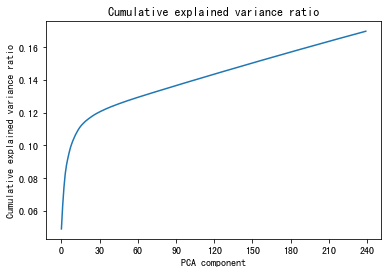

(70988, 240)
(70988, 140)
CPU times: user 4min 47s, sys: 14.8 s, total: 5min 2s
Wall time: 35.4 s


In [6]:
%%time
# Preprocessing

class PreprocessCiteseq(BaseEstimator, TransformerMixin):
    columns_to_use = 12000
    
    @staticmethod
    def take_column_subset(X):
        return X[:,-PreprocessCiteseq.columns_to_use:]
    
    def transform(self, X):
        print(X.shape)
        X = X[:,~self.all_zero_columns]
        print(X.shape)
        X = PreprocessCiteseq.take_column_subset(X) # use only a part of the columns
        print(X.shape)
        gc.collect()

        X = self.pca.transform(X)
        print(X.shape)
        return X

    def fit_transform(self, X):
        gc.collect()
        print(X.shape)
        self.all_zero_columns = (X == 0).all(axis=0)
        X = X[:,~self.all_zero_columns]
        print(X.shape)
        X = PreprocessCiteseq.take_column_subset(X) # use only a part of the columns
        print(X.shape)
        gc.collect()

        self.pca = PCA(n_components=240, copy=False, random_state=1)
        X = self.pca.fit_transform(X)
        plt.plot(self.pca.explained_variance_ratio_.cumsum())
        plt.title("Cumulative explained variance ratio")
        plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
        plt.xlabel('PCA component')
        plt.ylabel('Cumulative explained variance ratio')
        plt.show()
        print(X.shape)
        return X

preprocessor = PreprocessCiteseq()

cite_train_x = None
cite_train_x = preprocessor.fit_transform(pd.read_hdf(FP_CITE_TRAIN_INPUTS).values)

cite_train_y = pd.read_hdf(FP_CITE_TRAIN_TARGETS).values
print(cite_train_y.shape)

In [6]:
%%time
# Cross-validation

kf = KFold(n_splits=5, shuffle=True, random_state=1)
score_list = []
for fold, (idx_tr, idx_va) in enumerate(kf.split(cite_train_x)):
    model = None
    gc.collect()
    X_tr = cite_train_x[idx_tr] # creates a copy, https://numpy.org/doc/stable/user/basics.copies.html
    y_tr = cite_train_y[idx_tr]

    model = Ridge(copy_X=False) # overwrites the copied data
    model.fit(X_tr, y_tr)
    del X_tr, y_tr
    gc.collect()

    # We validate the model
    X_va = cite_train_x[idx_va]
    y_va = cite_train_y[idx_va]
    y_va_pred = model.predict(X_va)
    mse = mean_squared_error(y_va, y_va_pred)
    corrscore = correlation_score(y_va, y_va_pred)
    del X_va, y_va

    print(f"Fold {fold}: mse = {mse:.5f}, corr =  {corrscore:.3f}")
    score_list.append((mse, corrscore))

# Show overall score
result_df = pd.DataFrame(score_list, columns=['mse', 'corrscore'])
print(f"{Fore.GREEN}{Style.BRIGHT}Average  mse = {result_df.mse.mean():.5f}; corr = {result_df.corrscore.mean():.3f}{Style.RESET_ALL}")


Fold 0: mse = 2.66915, corr =  0.888
Fold 1: mse = 2.67049, corr =  0.888
Fold 2: mse = 2.66776, corr =  0.889
Fold 3: mse = 2.69190, corr =  0.888
Fold 4: mse = 2.67253, corr =  0.887
Average  mse = 2.67437; corr = 0.888
CPU times: user 13 s, sys: 2.88 s, total: 15.9 s
Wall time: 10.4 s


This ridge regression is far better than DummyRegressor, which has the score `mse = 4.87618; corr = 0.805`.

# Retraining

We retrain the model on all training rows, delete the training data, load the test data and compute the predictions.

In [7]:
model = None # free the RAM occupied by the old model
model = Ridge(copy_X=False) # we overwrite the training data
model.fit(cite_train_x, cite_train_y)
del cite_train_x, cite_train_y
gc.collect()

cite_test_x = preprocessor.transform(pd.read_hdf(FP_CITE_TEST_INPUTS).values)
test_pred = model.predict(cite_test_x)
del cite_test_x
test_pred.shape

(48663, 22050)
(48663, 21601)
(48663, 12000)
(48663, 240)


(48663, 140)

# Submission

We save the CITEseq predictions so that they can be merged with the Multiome predictions in the [Multiome quickstart notebook](https://www.kaggle.com/ambrosm/msci-multiome-quickstart).

The CITEseq test predictions produced by the ridge regressor have 48663 rows (i.e., cells) and 140 columns (i.e. proteins). 48663 * 140 = 6812820.


In [8]:
with open('citeseq_pred.pickle', 'wb') as f: pickle.dump(test_pred, f) # float32 array of shape (48663, 140)

The final submission will have 65744180 rows, of which the first 6812820 are for the CITEseq predictions and the remaining 58931360 for the Multiome predictions. 

We now read the Multiome predictions and merge the CITEseq predictions into them:

In [9]:
with open("../input/msci-multiome-quickstart/partial_submission_multi.pickle", 'rb') as f: submission = pickle.load(f)
submission.iloc[:len(test_pred.ravel())] = test_pred.ravel()
assert not submission.isna().any()
submission = submission.round(6) # reduce the size of the csv
submission.to_csv('submission.csv')
submission


row_id
0           0.596451
1           0.299572
2           0.624435
3           4.191335
4           5.107242
              ...   
65744175    7.271666
65744176    0.017597
65744177    0.025040
65744178    1.933743
65744179    5.111444
Name: target, Length: 65744180, dtype: float32